# Optimal Unitary Gate 

This notebook will serve as a test ground for implementing an optimal unitary gate in a dissapative system.

In [479]:
# Import libraries
import numpy as np

import time

import torch
from torch import nn
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler

from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt

In [480]:
# Mac M1 GPU Support
device = torch.device("cpu")
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())

True


In [481]:
# Define type for torch
exp_dtype = torch.complex128

# Define Pauli matrices for two level system
sigma_x = torch.tensor([[0,1],[1,0]], dtype=exp_dtype).to(device) 
sigma_y = torch.tensor([[0,-1j],[1j,0]], dtype=exp_dtype).to(device) 
sigma_z = torch.tensor([[1,0],[0,-1]], dtype=exp_dtype).to(device) 
sigma_plus = torch.tensor([[0, 1], [0, 0]], dtype=exp_dtype).to(device) 
sigma_minus = torch.tensor([[0, 0], [1, 0]], dtype=exp_dtype).to(device) 
I = torch.eye(2, dtype=exp_dtype).to(device) 

# Multiple spin operators
def X_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_x
        ), torch.eye(2**(N-(k)))
    )

def Y_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_y
        ), torch.eye(2**(N-(k)))
    )

def Z_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_z
        ), torch.eye(2**(N-(k)))
    )

def sigma_plus_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_plus
        ), torch.eye(2**(N-(k)))
    )

def sigma_minus_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_minus
        ), torch.eye(2**(N-(k)))
    )

def U_k(U, k, N):
    # arbitrary unitary for N spins
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), U
        ), torch.eye(2**(N-(k)))
    )

In [482]:
# Dice up the time
Ti, Tf = 0, 10e-9 # seconds
M = 250
dt = (Tf - Ti) / M

t_units = np.linspace(Ti, Tf, M)

# Number of spins
N = 3
isDispersive = False

# Plotting help
def bloch_animation(spin_num, rhos, plot=False): 
    x,y,z,r=[],[],[],[] 
    for rho in rhos:
        X = np.real(np.trace(np.dot(rho, X_k(spin_num, N))))
        Y = np.real(np.trace(np.dot(rho, Y_k(spin_num, N))))
        Z = np.real(np.trace(np.dot(rho, Z_k(spin_num, N))))
        R = np.sqrt(X**2 + Y**2 + Z**2)
        x.append(X)
        y.append(Y) 
        z.append(Z)
        r.append(R)

    if plot:
        plt.plot(t_units, x, c='r', label=r"$x(t)$")
        plt.plot(t_units, y, c='b', label=r"$y(t)$")
        plt.plot(t_units, z, c='g', label=r"$z(t)$")
        plt.title("Spin #{}".format(spin_num))
        plt.legend(loc='best')
        plt.savefig("./results/spin_{}_xyz_state.png".format(spin_num), dpi=300, bbox_inches="tight")
        plt.show()

        plt.plot(t_units, r, c='k', label=r"$r(t)$")
        plt.title("R Value")
        plt.ylim([0,2])
        plt.legend(loc='best')
        plt.savefig("./results/spin_{}_r_value.png".format(spin_num), dpi=300, bbox_inches="tight")
        plt.show()

        print(f"Starting: [{x[0]}, {y[0]}, {z[0]}] \n")
        print(f"Ending: [{x[-1]}, {y[-1]}, {z[-1]}]")
    else:
        return r


In [483]:
# Fourier series expansion
def fourier_series(t,*coeffs):
    n = len(coeffs[0])
    omega = 2 * np.pi / (t[-1]-t[0])
    f = torch.zeros_like(t, dtype=exp_dtype)
    for i in range(n):
        f += coeffs[0][i].repeat(len(t)) * np.sin(i * omega * t)
    return f

def g_fourier_series(t, *coeffs):
    num_of_g = coeffs[0].shape[0]
    all_gs = []
    for i in range(num_of_g):
        all_gs.append(fourier_series(t, coeffs[0][i]))
    return all_gs

def phi_fourier_series(t, *coeffs):
    # adds offset since phi doesnt have to start and stop @ zero.
    n = len(coeffs[0])
    omega = 2 * np.pi / (t[-1]-t[0])
    f = torch.zeros_like(t, dtype=exp_dtype)
    f += coeffs[0][-1]
    for i in range(n-1):
        f += coeffs[0][i].repeat(len(t)) * np.sin(i * omega * t)
    return f

K = 5 # Number of harmonics
scale = 1e4

B_rf_coeffs = Variable(torch.tensor(np.random.randn(K)/scale, dtype=exp_dtype), requires_grad=True)  
g_coeffs =  Variable(torch.tensor(np.random.randn(N,K)/scale, dtype=exp_dtype), requires_grad=True) 
phi_coeffs = Variable(torch.tensor(np.random.randn(K+1), dtype=exp_dtype), requires_grad=True) 

t_units_tensor = torch.tensor(t_units)

B_rf = fourier_series(t_units_tensor, B_rf_coeffs)
g_fourier = g_fourier_series(t_units_tensor, g_coeffs)
phi = phi_fourier_series(t_units_tensor, phi_coeffs)

g = []
for g_ in g_fourier:
    g.append(Variable(torch.tensor(g_, dtype=exp_dtype), requires_grad=True))

B_rf = Variable(torch.tensor(B_rf, dtype=exp_dtype), requires_grad=True)
phi = Variable(torch.tensor(phi, dtype=exp_dtype), requires_grad=True)

J_scale = 1e34

def construct_J_signal(t, sigma, *coeffs):
 
    J = torch.zeros_like(t, dtype=exp_dtype)
    skip = int(2.5 * sigma // dt) # skip X standard deviations
    for i in range(skip, M-skip, 2):
        gaussian = torch.exp(-(t - i * dt)**2 / (2 * sigma**2)) / J_scale
        J += coeffs[0][i].repeat(len(t)) * gaussian

    return J

def build_J(t, sigma, *coeffs):
    num_of_J = coeffs[0].shape[0]
    all_Js = []
    for i in range(num_of_J):
        all_Js.append(construct_J_signal(t, sigma, coeffs[0][i]))
    return all_Js

# np.zeros((N-1, M))
# np.random.randn(N-1, M)
J_coeffs =  Variable(torch.tensor(np.random.randn(N-1, M), dtype=exp_dtype), requires_grad=True) # Random initial coefficients


sigma = 7 * dt
J = build_J(t_units_tensor,sigma, torch.abs(J_coeffs))

# plt.plot(t_units, B_rf.cpu().detach().numpy())
# plt.show()

# for J_ in J:
#     plt.plot(t_units, J_.cpu().detach().numpy())
# plt.show()

# for g_ in g:
#     plt.plot(t_units, g_.cpu().detach().numpy())
# plt.show()


# plt.plot(t_units, phi.cpu().detach().numpy())
# plt.show()

# plt.plot(t_units, J.cpu().detach().numpy())
# plt.show()


/var/folders/y8/698phn_j78qg7mclyy6h62r00000gn/T/ipykernel_5772/3429821662.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g.append(Variable(torch.tensor(g_, dtype=exp_dtype), requires_grad=True))
/var/folders/y8/698phn_j78qg7mclyy6h62r00000gn/T/ipykernel_5772/3429821662.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B_rf = Variable(torch.tensor(B_rf, dtype=exp_dtype), requires_grad=True)
/var/folders/y8/698phn_j78qg7mclyy6h62r00000gn/T/ipykernel_5772/3429821662.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = Variabl

In [484]:
# Helper functions to construct Lindbladian superoperator
def kron(A, B):
    return (A[:, None, :, None] * B[None, :, None, :]).reshape(A.shape[0] * B.shape[0], A.shape[1] * B.shape[1])
def kron_einsum(A,B):
    return torch.einsum("ij, kl->ikjl", A, B).view(A.size(0) * B.size(0), A.size(1)* B.size(1))
def hermitian_conj(A):
    return torch.conj(A).transpose(0,1)
def batch_kron(a, b):
    """
    Kronecker product of matrices a and b with leading batch dimensions.
    Batch dimensions are broadcast. The number of them mush
    :type a: torch.Tensor
    :type b: torch.Tensor
    :rtype: torch.Tensor
    """
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)

# Define constants
muB = 9.27e-24 # J/T
hbar = 1.055e-34 # Js
B0 = 607.285 * 1e-3 # Tesla, Bohdan's thesis page 120
kB = 1.38e-23 # J/K

w = 2 * muB * B0 / hbar # Larmor freq
on_resonance = True

f_rf = 17e9 # Hz
w_rf = 2 * np.pi * f_rf if not(on_resonance) else w 

# Define Lindblad operators
Te = 4 # K
T1 = 10e-3 # seconds
T2 = 10e-6 # seconds
P_up = 1 / (np.exp(hbar * w / (kB * Te)) + 1)
P_down = 1 - P_up

def L1_j(j, pj, T1, N):
    return U_k(np.sqrt(pj/(2*T1) * sigma_plus), j, N)
def L2_j(j, pj, T1, N):
    return U_k(np.sqrt((1-pj)/(2*T1) * sigma_minus), j, N)
def L3_j(j, T2, N):
    return U_k(np.sqrt(1/(2*np.sqrt(T2)) * sigma_z), j, N)

L1 = []
L2 = []
L3 = []

pj = P_up
for j in range(1, N+1):
    L1.append(L1_j(j, pj, T1, N))
    L2.append(L2_j(j, pj, T1, N))
    L3.append(L3_j(j, T2, N))
L = [L1, L2, L3]


# Construct superoperator 
def construct_superop(g, B_rf, phi, J, L, N, dispersive=False):

    H = torch.zeros((M, 2**(N), 2**(N)), dtype=exp_dtype) # must be faster way ??
    for k in range(1,N+1):
        H += 0.5 * ((1 + g[k-1].view(-1, 1, 1)/2) * w - w_rf) * Z_k(k, N).repeat(M, 1, 1) + 0.5 * (2 * muB / hbar) * B_rf.view(-1, 1, 1) * (torch.cos(phi).view(-1, 1, 1) * X_k(k, N).repeat(M, 1, 1) + torch.sin(phi).view(-1, 1, 1) * Y_k(k,N).repeat(M, 1, 1))

    if N >= 2:    
        for j in range(1, N): # Issue if N > 2
            H += ( J[j-1].view(-1,1,1) / (4 * hbar) ) * (torch.mm(X_k(j, N), X_k(j+1, N)) + torch.mm(Y_k(j, N), Y_k(j+1, N)) + torch.mm(Z_k(j, N), Z_k(j+1, N))).repeat(M, 1, 1)

    Gamma = torch.zeros((M, 2**(2 * N), 2**(2 * N)), dtype=exp_dtype)
    for alpha in range(3):
        for j in range(N):
            Gamma += 2 * batch_kron(L[alpha][j].repeat(M,1,1), L[alpha][j].repeat(M,1,1)) - (batch_kron(torch.eye(2**N).repeat(M,1,1), torch.matmul(hermitian_conj(L[alpha][j]), L[alpha][j]).repeat(M,1,1)) + batch_kron(torch.matmul(L[alpha][j].transpose(0,1), L[alpha][j].conj()).repeat(M,1,1), torch.eye(2**N).repeat(M,1,1)))

    L = -1j * (batch_kron(H, torch.eye(2**N).repeat(M,1,1)) - batch_kron(torch.eye(2**N).repeat(M,1,1), H.transpose(1,2))) + int(dispersive) * Gamma
    exp_L = torch.matrix_exp(L * dt)
    L_F = torch.chain_matmul(*exp_L)
    return L_F

def evolve_rho(rho0, g, B_rf, phi, J, L, N, dispersive = False):
    H = torch.zeros((M, 2**(N), 2**(N)), dtype=exp_dtype) # must be faster way ??
    for k in range(1,N+1):
        H += 0.5 * ((1 + g[k-1].view(-1, 1, 1)/2) * w - w_rf) * Z_k(k, N).repeat(M, 1, 1) + 0.5 * (2 * muB / hbar) * B_rf.view(-1, 1, 1) * (torch.cos(phi).view(-1, 1, 1) * X_k(k, N).repeat(M, 1, 1) + torch.sin(phi).view(-1, 1, 1) * Y_k(k,N).repeat(M, 1, 1))
    
    if N >= 2:
        for j in range(1, N): # Issue if N > 2
            H += ( J[j-1].view(-1,1,1) / (4 * hbar) ) * (torch.mm(X_k(j, N), X_k(j+1, N)) + torch.mm(Y_k(j, N), Y_k(j+1, N)) + torch.mm(Z_k(j, N), Z_k(j+1, N))).repeat(M, 1, 1)

    Gamma = torch.zeros((M, 2**(2 * N), 2**(2 * N)), dtype=exp_dtype)
    for alpha in range(3):
        for j in range(N):
            Gamma += 2 * batch_kron(L[alpha][j].repeat(M,1,1), L[alpha][j].repeat(M,1,1)) - (batch_kron(torch.eye(2**N).repeat(M,1,1), torch.matmul(hermitian_conj(L[alpha][j]), L[alpha][j]).repeat(M,1,1)) + batch_kron(torch.matmul(L[alpha][j].transpose(0,1), L[alpha][j].conj()).repeat(M,1,1), torch.eye(2**N).repeat(M,1,1)))

    L = -1j * (batch_kron(H, torch.eye(2**N).repeat(M,1,1)) - batch_kron(torch.eye(2**N).repeat(M,1,1), H.transpose(1,2))) + int(dispersive) * Gamma
    exp_L = torch.matrix_exp(L * dt)
 
    rhos = torch.zeros((M, 2, 2), dtype=exp_dtype)

    def custom_cumprod(tensor):
        result = []
        product = tensor[0]
        result.append(product)

        for i in range(1, tensor.shape[0]):
            product = torch.mm(product, tensor[i])
            result.append(product)

        return torch.stack(result)

    cumprod_exp_L = custom_cumprod(exp_L)

    rho0_extended = rho0.view(-1,).repeat(M,1,1).transpose(1,2)

    rhos = torch.bmm(cumprod_exp_L, rho0_extended).view(-1,2**N,2**N)
    return rhos

def get_xyz_state(rho):
    print(rho)
    X = torch.real(torch.trace(torch.mm(rho, sigma_x)))
    Y = torch.real(torch.trace(torch.mm(rho, sigma_y)))
    Z = torch.real(torch.trace(torch.mm(rho, sigma_z)))
    
    return X,Y,Z

t0 = time.time()
L_F = construct_superop(g, B_rf, phi, J, L, N, isDispersive)
print("Time to create superoperator: ", time.time() - t0)

# print(torch.count_nonzero(construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive))/torch.numel(construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive)))

Time to create superoperator:  0.5121440887451172


In [485]:
### Desired operator
def RX(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -1j * np.sin(theta/2)], [-1j * np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)
def RY(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)

theta =np.pi/2

UF_ = RX(theta)
SWAP12 = torch.kron(torch.from_numpy(np.array([[1, 0, 0, 0], [0,0,1,0], [0,1,0,0], [0,0,0,1]])).type(exp_dtype),torch.eye(N-1))
SWAP23 = torch.kron(torch.eye(2), torch.from_numpy(np.array([[1, 0, 0, 0], [0,0,1,0], [0,1,0,0], [0,0,0,1]])).type(exp_dtype))
UF = torch.kron(UF_, torch.eye(2**(N-1))) 
# UF = torch.mm(SWAP12, torch.mm(SWAP12,SWAP23))
# UF = SWAP12
# UF = UF_
L_desired = torch.kron(UF.conj(), UF)

# Check out density matrices
rho0_spin1 =  torch.from_numpy(np.array([[1,0],[0,0]])).type(exp_dtype) # psi0 = |g>
rho0_spin2 =  torch.from_numpy(np.array([[0,0],[0,1]])).type(exp_dtype) # psi0 = |e>
rho0_spin3 =  torch.from_numpy(np.array([[0,0],[0,1]])).type(exp_dtype) # psi0 = |g>

# rho0 = torch.kron(rho0_spin1, rho0_spin2) if N == 2 else rho0_spin1
rho0 = torch.kron(torch.kron(rho0_spin1, rho0_spin2),rho0_spin3)
# rho0 = rho0_spin1
rho_desired = torch.matmul(
            L_desired, rho0.view(-1,)
        )
rho = torch.matmul(
            construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive), rho0.view(-1,)
        )

print(rho_desired.view(2**N,2**N))
print(rho.view(2**N,2**N))

tensor([[0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j,
         0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j,
         0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j,
         0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.5000+0.0000j,
         0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000-0.5000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j,
         0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j,
         0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j,
         0.0000+0.0000j, 0.0000+0.0000j, 0.00

In [486]:
from torch.fft import fft

class CostFunction(nn.Module):
    def __init__(self):
        super(CostFunction, self).__init__()

    def fidelity(self, output, target):
        fid = torch.abs(torch.trace(
            torch.mm(
                hermitian_conj(output), target
            )
        )) / (2**(2*N))

        return fid
    
    def forward(self, output, target):

        fid = self.fidelity(output,target)

        operator_dist = nn.L1Loss()
        p = 0.5
        return p * (fid-1)**2 + (1-p) * operator_dist(output, target), fid

# opt_params = [g_coeffs.to(device), B_rf_coeffs.to(device), phi_coeffs.to(device)]
lr_dict = {'g': 1e-3, 'B_rf': 1e-3, 'phi': 1e-2, 'J': 1e10}
optimizer = torch.optim.Adam(
        [{'params': g_coeffs, 'lr': lr_dict['g']},
         {'params': B_rf_coeffs, 'lr': lr_dict['B_rf']},
         {'params': phi_coeffs, 'lr': lr_dict['phi'],},
         {'params': J_coeffs, 'lr': lr_dict['J']}],
        )

criterion = CostFunction()

epochs = 1000
loss_array = []

threshold = 0.99

for i in range(epochs):
    
    optimizer.zero_grad()

    B_rf = fourier_series(t_units_tensor, B_rf_coeffs)
    g = g_fourier_series(t_units_tensor, g_coeffs)
    phi = phi_fourier_series(t_units_tensor, phi_coeffs)
    J = build_J(t_units_tensor,sigma, torch.abs(J_coeffs))
    
    L_output = construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive)
    
    loss, fid = criterion(L_output, L_desired)

    loss.backward()
    optimizer.step()

    loss_array.append(loss.item())
 
    if i % 50 == 0:
        print("Step {}: Loss = {}, Fidelity = {}".format(i, loss.item(), fid))

    if fid > threshold and fid < 1:
        break

L_output = construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive)

Step 0: Loss = 0.13922719600010108, Fidelity = 0.5029007565485093


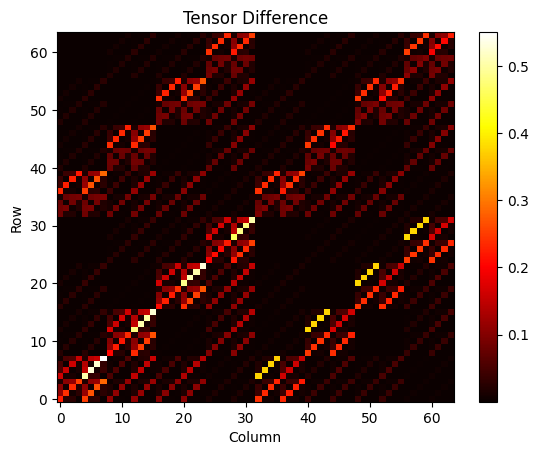

In [487]:
def plot_tensor_difference(tensor1, tensor2):
    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape"

    N = tensor1.shape[0]

    # Calculate the absolute difference between the tensors
    diff = np.abs(tensor1 - tensor2)

    # Create a grid for the plot
    xx, yy = np.meshgrid(range(N), range(N))

    # Plot the tensor difference as a grid
    plt.pcolormesh(xx, yy, diff, cmap='hot', shading='auto')
    plt.colorbar()
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title('Tensor Difference')
    plt.show()
plot_tensor_difference(L_output.detach().numpy(), L_desired.detach().numpy())




Final Unitary Fidelity = 
 tensor(0.9976, dtype=torch.float64, grad_fn=<DivBackward0>)


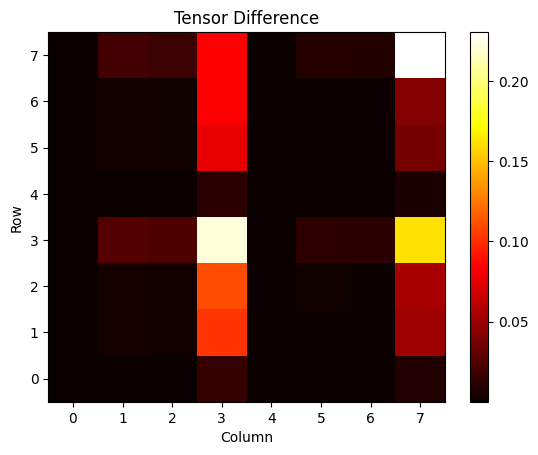

In [488]:
# print("Output superoperator, \n ",L_output)
# print("Desired superoperator, \n ", L_desired)
print("Final Unitary Fidelity = \n",fid)

# See what L_f does to initial state
rho_out = torch.matmul(
            L_output, rho0.view(-1,)
        )

def fidelity_states(rho, sigma):
    # rho is output 
    sqrt_rho = torch.pow(rho, 0.5)
    temp_mat = torch.mm(sqrt_rho, torch.mm(sigma, sqrt_rho))
    return (torch.trace(torch.pow(temp_mat, 0.5)))

rho_out = rho_out.view(2**N,2**N)
rho_theoretical = rho_desired.view(2**N,2**N)
# print("Rho Out: \n", rho_out)
# print("Rho Desired: \n", rho_theoretical)
# print("Rho fidelity: \n", fidelity_states(rho_out,rho_theoretical))
plot_tensor_difference(rho_out.detach().numpy(), rho_theoretical.detach().numpy())


# X,Y,Z = get_xyz_state(evolve_rho(rho0, g, B_rf, phi, J, L, N, dispersive=isDispersive)[-1])
# print("X,Y,Z = ({}, {}, {})".format(X,Y,Z))

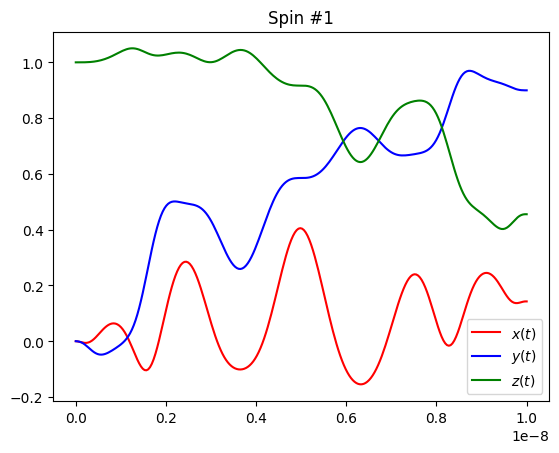

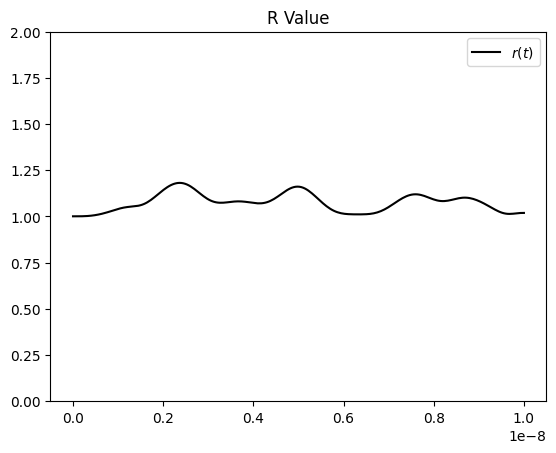

Starting: [0.0, 0.0, 0.9999999999999825] 

Ending: [0.14264473168758796, 0.8996387388804229, 0.4553077213681319]


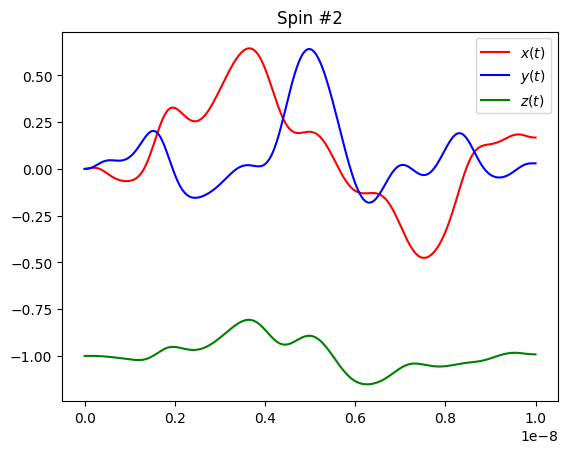

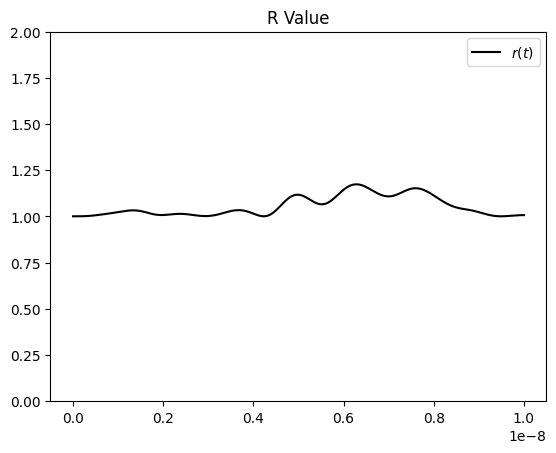

Starting: [0.0, 0.0, -0.9999999999999825] 

Ending: [0.16779264237718156, 0.029756486987727412, -0.9917938692276903]


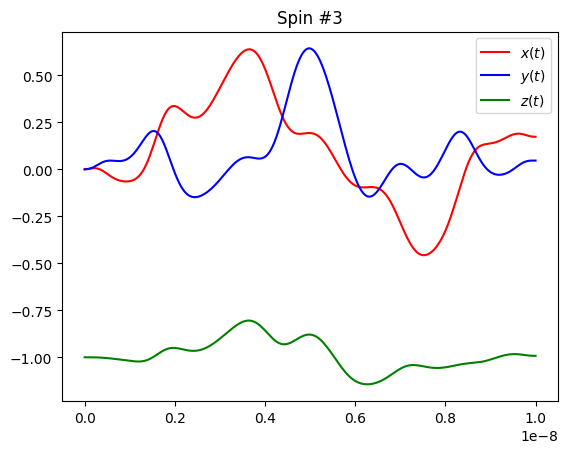

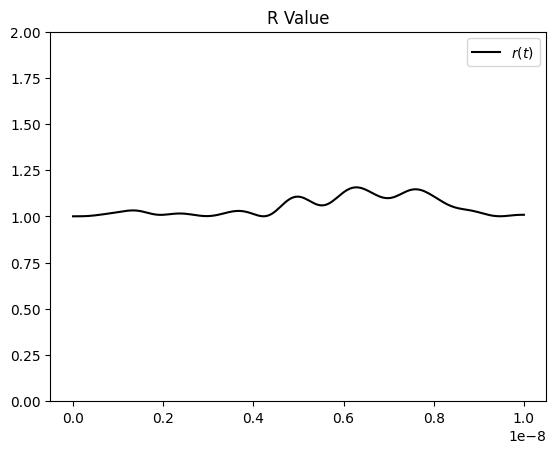

Starting: [0.0, 0.0, -1.0] 

Ending: [0.17317344279369215, 0.04643035211459121, -0.992194785051052]


In [489]:
for i in range(1,N+1):
    bloch_animation(i, evolve_rho(rho0, g, B_rf, phi, J, L, N, dispersive=isDispersive).detach().numpy(), plot=True)

# bloch_animation(3, evolve_rho(rho0, g, B_rf, phi, J, L, N, dispersive=isDispersive).detach().numpy(), plot=True)

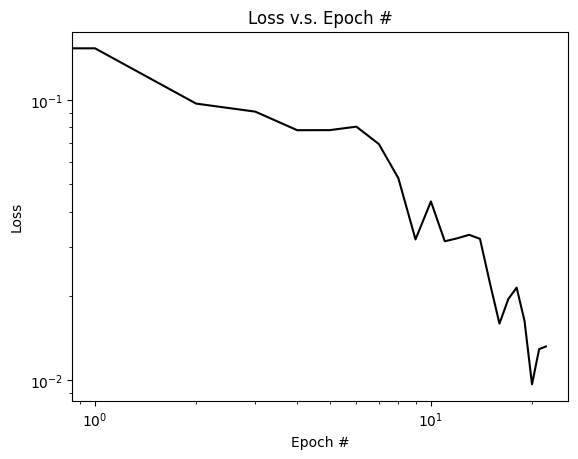

/Users/andrijapaurevic/opt/anaconda3/envs/opt_control/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


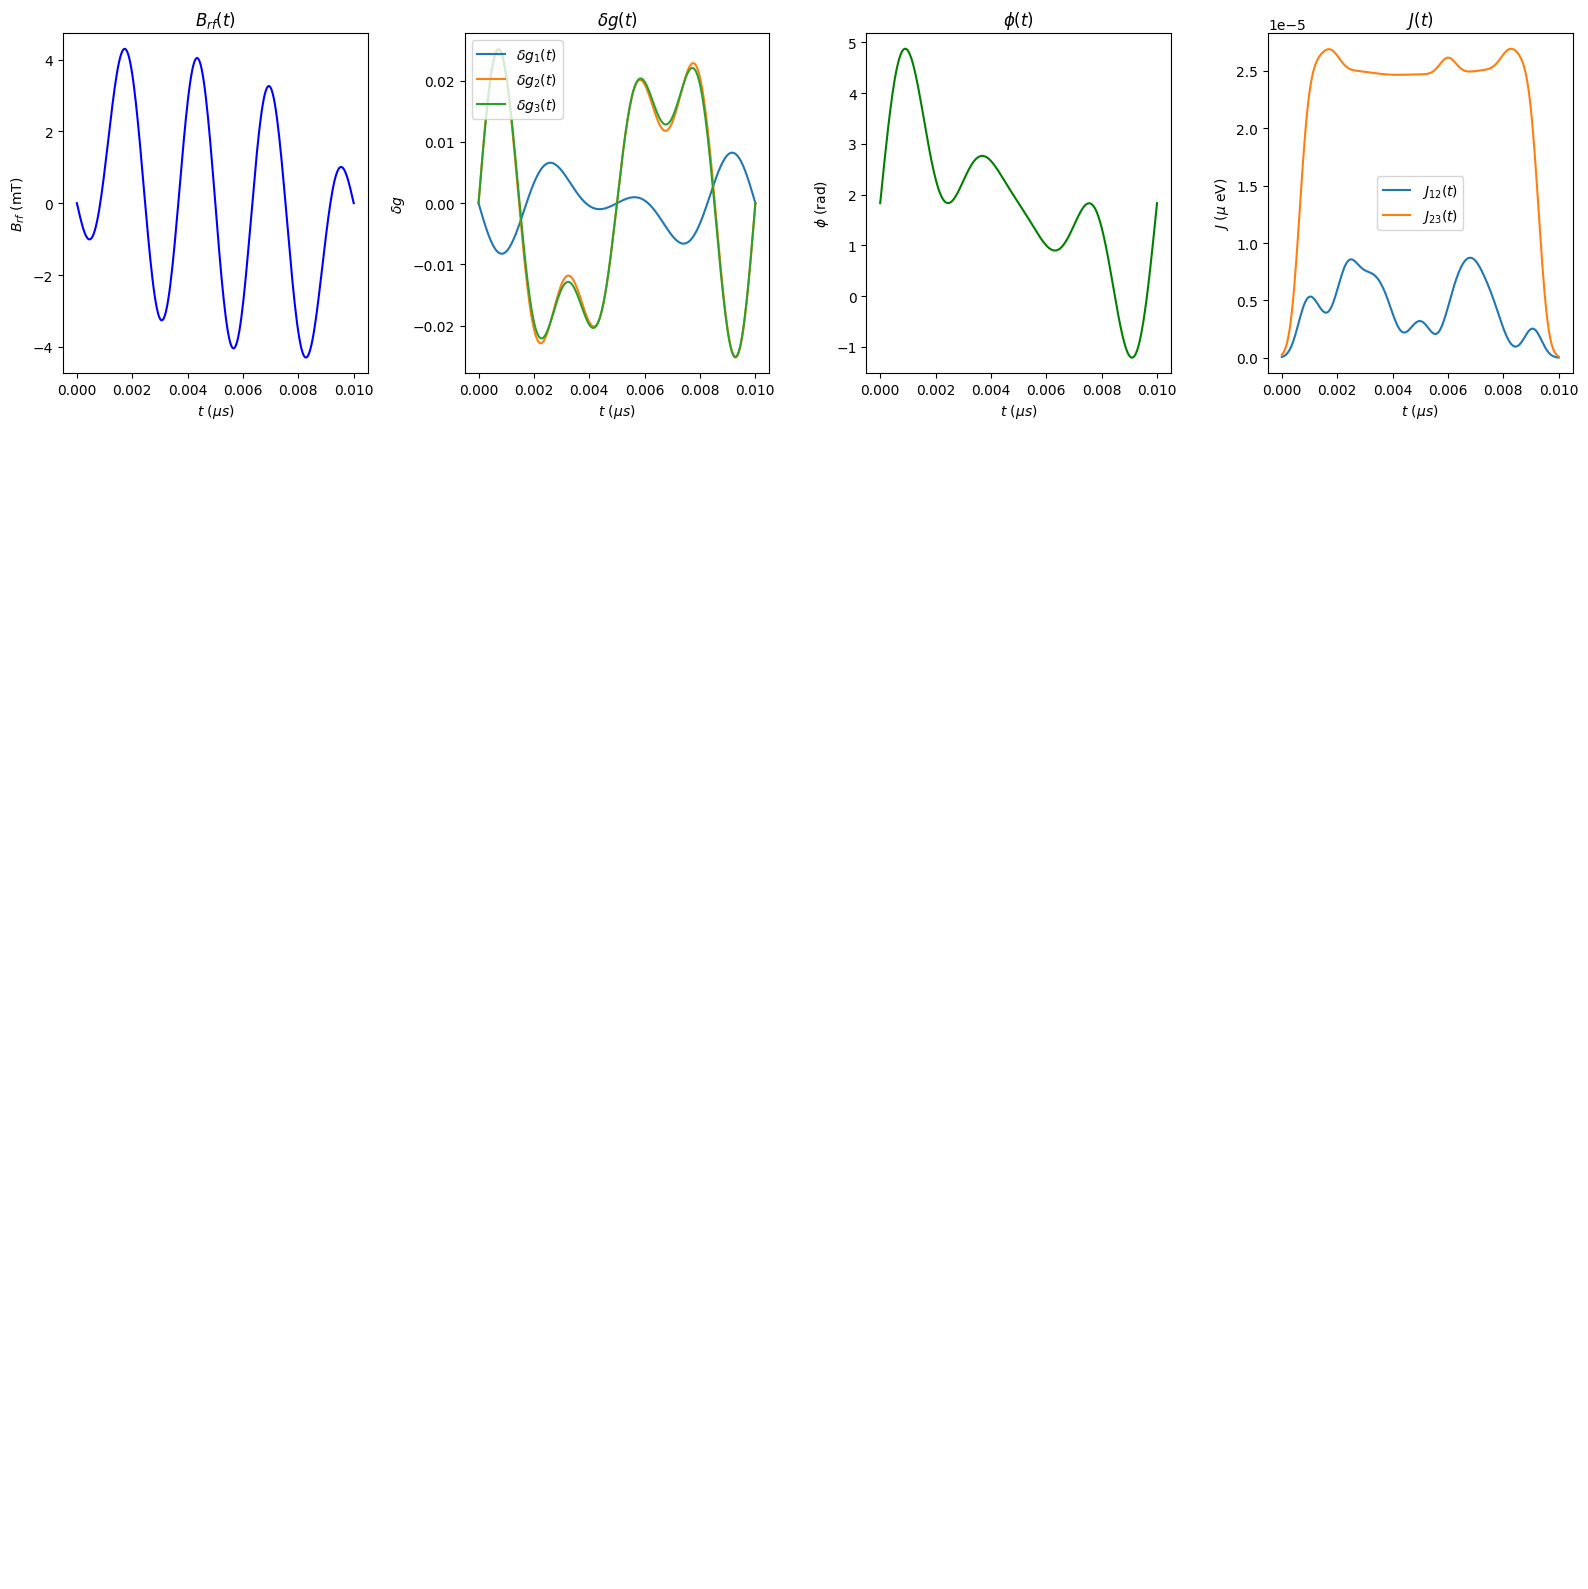

In [490]:

# Print cost fxn 
plt.loglog(loss_array, 'k')
plt.title("Loss v.s. Epoch #")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.savefig('./results/loss.png', dpi=350, bbox_inches="tight")
plt.show()

# Show trained parameters
plt.plot(1e6 * t_units, 1e3 * B_rf.detach().numpy(), 'b')
plt.title(r"$B_{rf}(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$B_{rf}\ $(mT)")
plt.savefig('./results/B_rf.png', dpi=350, bbox_inches="tight")
plt.close()
# plt.show() 

# Plot g
for i in range(len(g)):
    plt.plot(1e6 * t_units, g[i].detach().numpy(), label=f"$\delta g_{i+1}(t)$")
plt.title(r"$\delta g(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$\delta g$")
plt.legend(loc='best')
plt.savefig('./results/delta_g.png', dpi=350, bbox_inches="tight")
plt.close()
# plt.show() 

plt.plot(1e6 * t_units, phi.detach().numpy(), 'g')
plt.title(r"$\phi(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$\phi$ (rad)")
plt.savefig('./results/phi.png', dpi=350, bbox_inches="tight")
plt.close()
# plt.show()

# Plot J
for i in range(len(J)):
    plt.plot(1e6 * t_units, J[i].detach().numpy()/((6.242e-18) * 1e-6),label= r"$J_{{{}{}}}(t)$".format(i+1, i+2))
plt.title(r"$J(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$J$ ($\mu$eV)")
plt.legend(loc='best')
plt.savefig('./results/J.png', dpi=350, bbox_inches="tight")
plt.close()
# plt.show()


# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Plot B_rf
axs[0, 0].plot(1e6 * t_units, 1e3 * B_rf.detach().numpy(), 'b')
axs[0, 0].set_title(r"$B_{rf}(t)$")
axs[0, 0].set_xlabel(r'$t\ (\mu s)$')
axs[0, 0].set_ylabel(r"$B_{rf}\ $(mT)")

# Plot g
for i in range(len(g)):
    axs[0, 1].plot(1e6 * t_units, g[i].detach().numpy(), label=f"$\delta g_{i+1}(t)$")
axs[0, 1].set_title(r"$\delta g(t)$")
axs[0,1].set_xlabel(r'$t\ (\mu s)$')
axs[0, 1].set_ylabel(r"$\delta g$")
axs[0, 1].legend()

# Plot phi
axs[0, 2].plot(1e6 * t_units, phi.detach().numpy(), 'g')
axs[0, 2].set_title(r"$\phi(t)$")
axs[0, 2].set_xlabel(r'$t\ (\mu s)$')
axs[0, 2].set_ylabel(r"$\phi$ (rad)")

if N >= 2:
    # Plot J
    for i in range(len(J)):
        axs[0, 3].plot(1e6 * t_units, J[i].detach().numpy()/((6.242e-18) * 1e-6),label= r"$J_{{{}{}}}(t)$".format(i+1, i+2))
    axs[0, 3].set_title(r"$J(t)$")
    axs[0, 3].set_xlabel(r'$t\ (\mu s)$')
    axs[0, 3].set_ylabel(r"$J$ ($\mu$ eV)")
    axs[0, 3].legend()
    # axs[0,3].set_ylim([0,1])

# Remove empty subplots
for i in range(1, 4):
    for j in range(4):
        axs[i, j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()
